In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from highlight_text import fig_text
from pyfonts import load_font
from pypalettes import get_hex
from utils import add_labels, get_label_rotation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
from matplotlib.transforms import Affine2D
from matplotlib.patches import Rectangle
from drawarrow import fig_arrow

df1 = pd.read_csv("data/employment.csv")
df1.drop(columns="disability", inplace=True)
df1["metric"] = "Employment"
df1.rename(columns={
    "count_employed": "value"
}, inplace=True)
df1_female = df1[df1["sex"]=="Female"]
df1_male = df1[df1["sex"]=="Male"]
df1 = df1_female.merge(
    df1_male,
    left_on=["island", "year", "age", "metric"],
    right_on=["island", "year", "age", "metric"],
    how="inner",
    suffixes=("_female", "_male")
)

df2 = pd.read_csv("data/education-level.csv")
df2.replace({
   "Early childhood education": "Highschool and below",
   "Primary education": "Highschool and below",
   "Lower secondary education": "Highschool and below",
   "Upper secondary education": "Highschool and below",
   "Post-secondary non-tertiary education": "After highschool",
   "Tertiary education": "After highschool"
}, inplace=True)
df2 = df2[df2["level"] == "After highschool"]
df2["metric"] = "education qualification"
df2.rename(columns={
    "count": "value"
}, inplace=True)
df2 = df2[df2["value"] < 1000]
df2_female = df2[df2["sex"]=="Female"]
df2_male = df2[df2["sex"]=="Male"]
df2 = df2_female.merge(
    df2_male,
    left_on=["island", "year", "age", "level", "metric"],
    right_on=["island", "year", "age", "level", "metric"],
    how="inner",
    suffixes=("_female", "_male")
)

df3 = pd.read_csv("data/management-position.csv")
df3.drop(columns="categories", inplace=True)
df3["metric"] = "management"
df3.rename(columns={
    "share_female_lead": "value"
}, inplace=True)
df3["value_male"] = 100 - df3["value"]
df3.rename(columns={"value": "value_female"}, inplace=True)

df = pd.concat([df1, df2, df3])
df.drop(columns=["sex_male", "sex_female", "level"], inplace=True)
df.replace("Micronesia (Federated States of)", "Micronesia", inplace=True)
df["name"] = df["island"]+" ("+df["age"]+" yo in "+df["year"].astype(str)+")"
df["name"] = ""

max_per_metric = df.groupby("metric")[["value_female", "value_male"]].max().reset_index()
max_per_metric.columns = ["metric", "max_female", "max_male"]
df = df.merge(max_per_metric, on="metric")
df["max"] = df[['max_female', 'max_female']].max(axis=1)
df["value_female_scaled"] = df["value_female"]/df["max"]*50
df["value_male_scaled"] = df["value_male"]/df["max"]*50

df["padding"] = df[["value_female_scaled", "value_male_scaled"]].max(axis=1) * 0.1
df.sort_values(by=["metric", "island", "age", "year"], inplace=True)
df.loc[df["metric"]=="education qualification", "value_female_scaled"] *= 1.6
df.loc[df["metric"]=="education qualification", "value_male_scaled"] *= 1.6
df.sample(10)

,island,year,value_female,age,metric,value_male,name,max_female,max_male,max,value_female_scaled,value_male_scaled,padding
42,Tuvalu,2015,37.9,25-54,management,62.1,,54.3,92.7,54.3,34.898711,57.182320,5.718232
39,Vanuatu,2019,26.8,55-64,management,73.2,,54.3,92.7,54.3,24.677716,67.403315,6.740331
54,Micronesia,2013,21.8,25-54,management,78.2,,54.3,92.7,54.3,20.073665,72.007366,7.200737
21,Nauru,2021,100.0,25-54,education qualification,11.0,,886.0,671.0,886.0,9.029345,0.993228,0.564334
52,Nauru,2012,34.1,25-54,management,65.9,,54.3,92.7,54.3,31.399632,60.681400,6.068140
10,Kiribati,2020,432.0,25-54,education qualification,390.0,,886.0,671.0,886.0,39.006772,35.214447,2.437923
3,Marshall Islands,2011,393.0,55-64,Employment,836.0,,7856.0,11450.0,7856.0,2.501273,5.320774,0.532077
20,Nauru,2021,14.0,25-54,education qualification,88.0,,886.0,671.0,886.0,1.264108,7.945824,0.496614
0,Kiribati,2019,7856.0,25-54,Employment,11450.0,,7856.0,11450.0,7856.0,50.000000,72.874236,7.287424
43,Tonga,2021,27.8,55-64,management,72.2,,54.3,92.7,54.3,25.598527,66.482505,6.648250


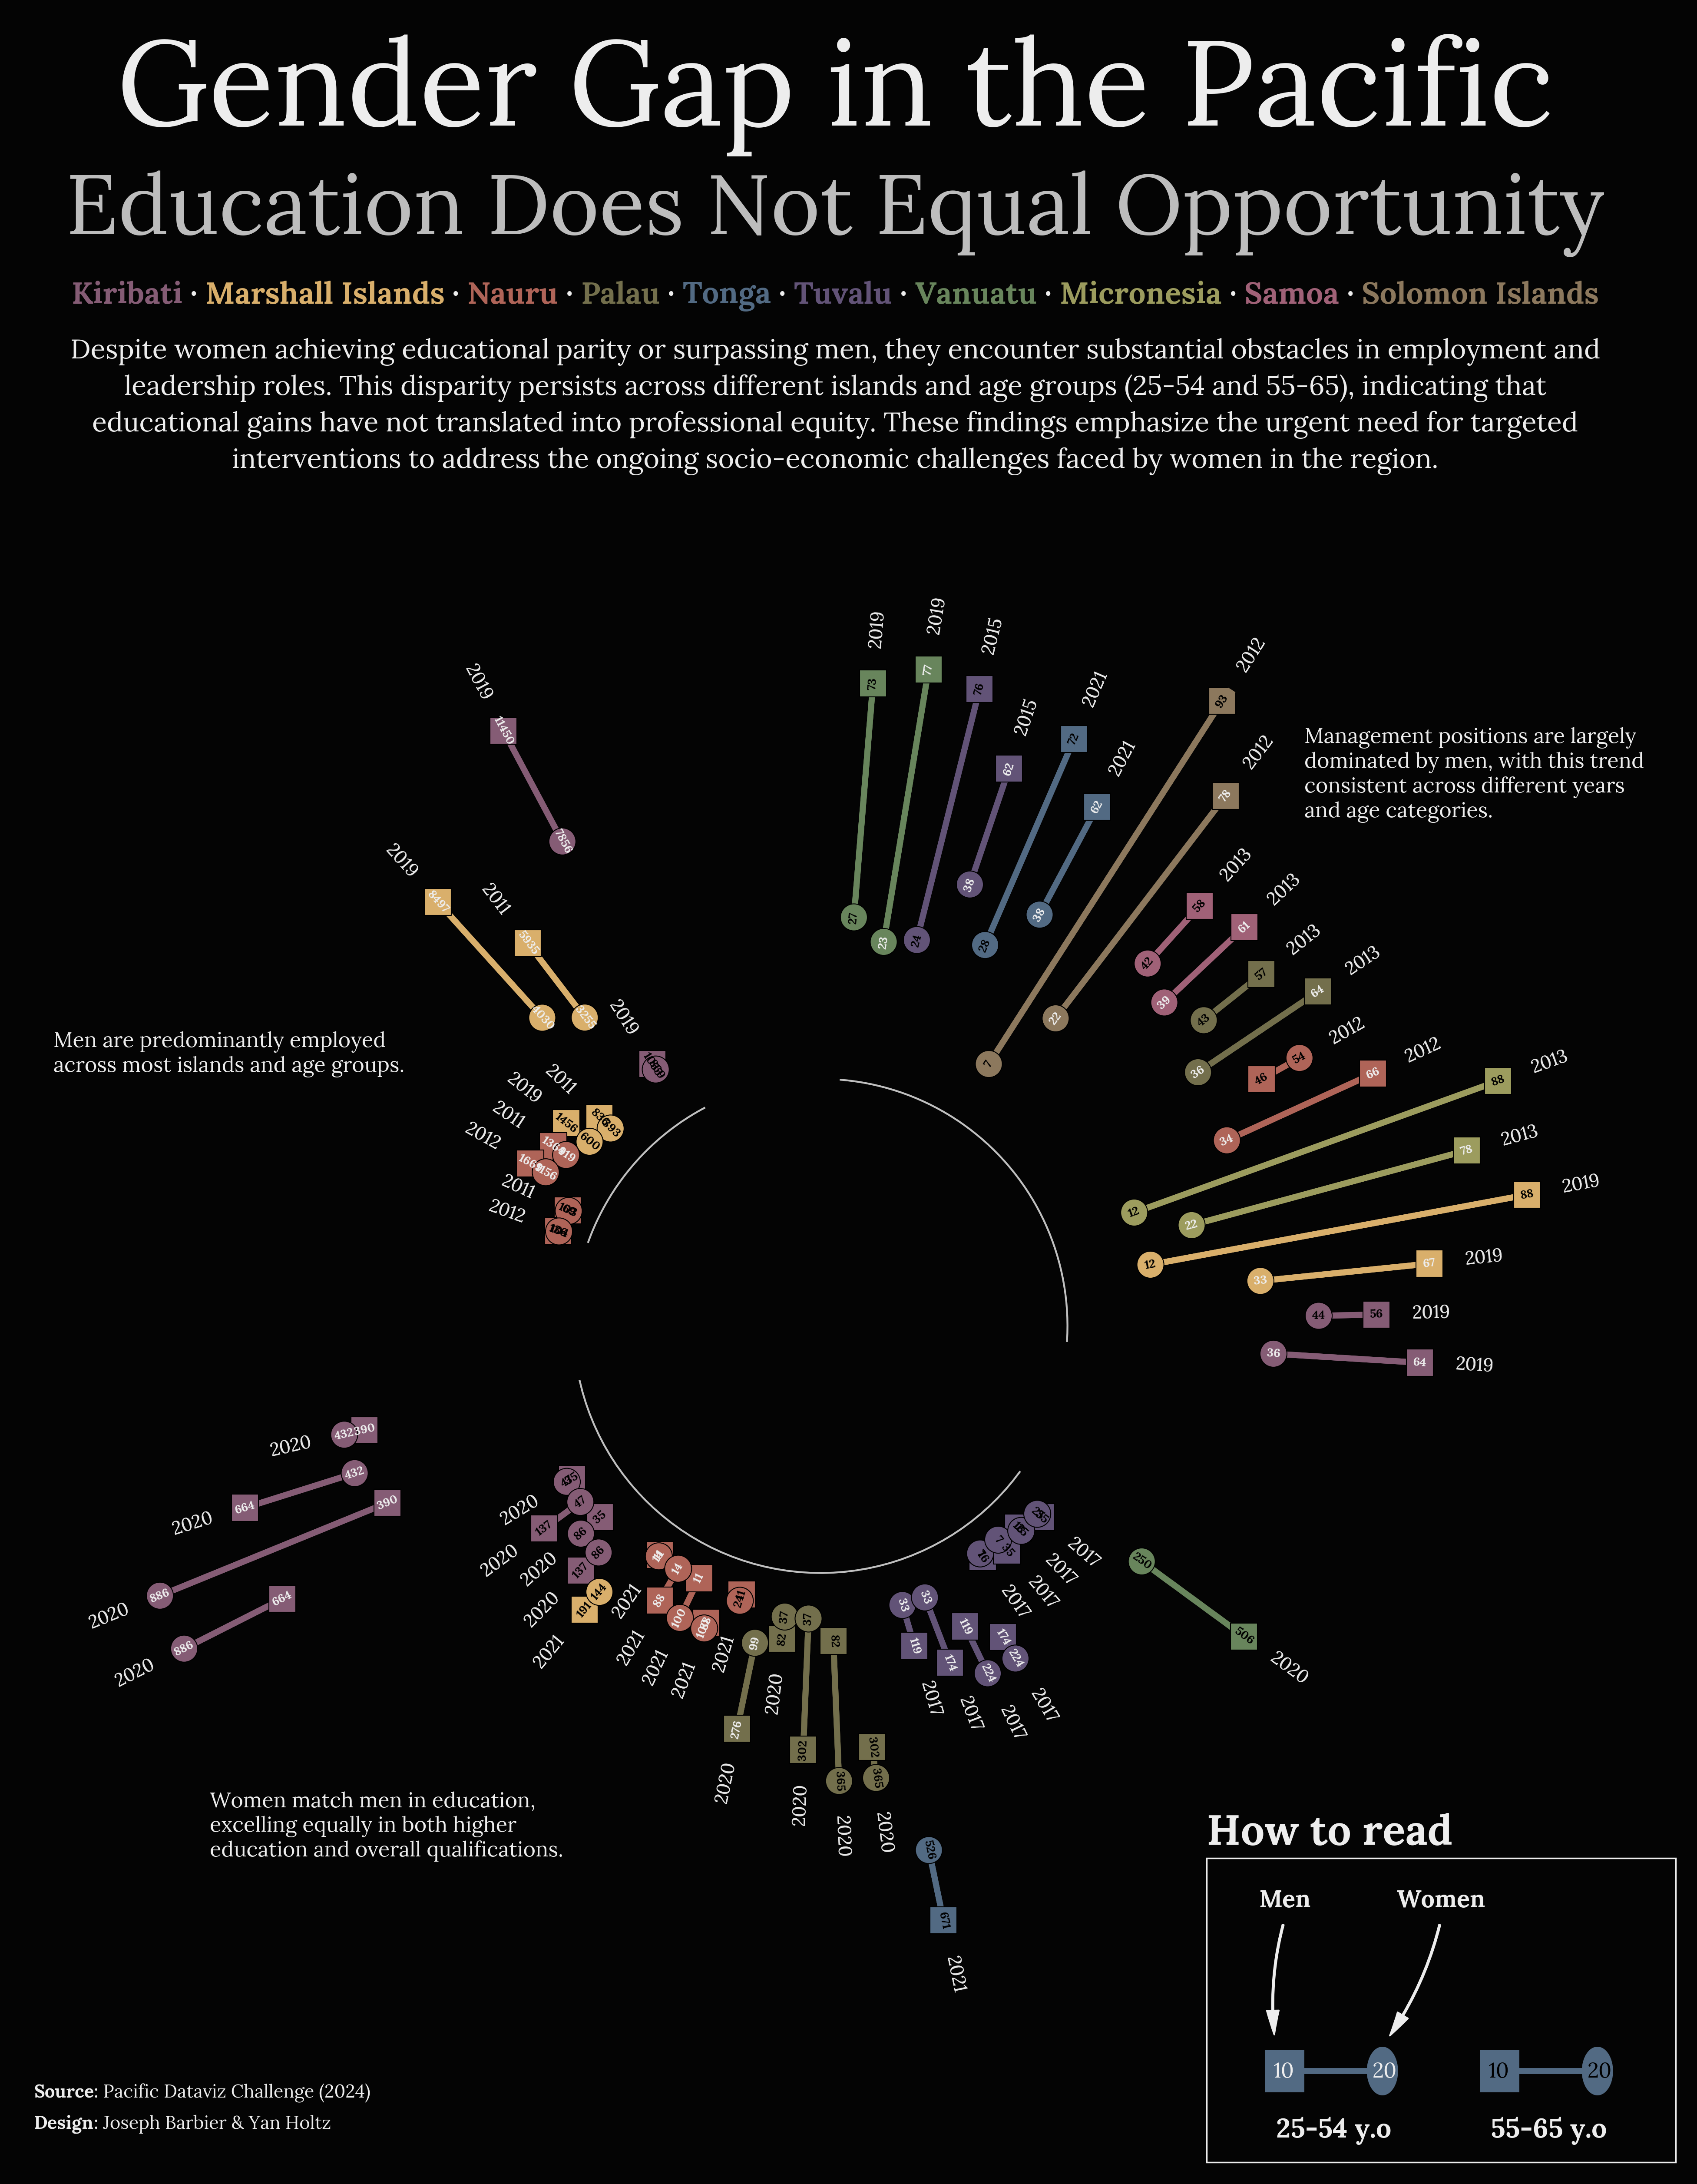

In [31]:
def get_alignement(angle, offset=0):
        if angle <= np.pi:
            alignment = 'right'
        else:
            alignment = 'left'
        return alignment

def get_label_rotation(angle):
    angle_deg = np.degrees(angle)
    rotation = (angle_deg + 90) % 360
    if 90 <= rotation < 270:
        rotation = (rotation + 180) % 360
    return rotation

def circular_lollipop(df, value, name, group, label_values, fig, ax, color_mapping, other_values, marker, year='year'):
    VALUES = df[value].values
    OTHER_VALUES = df[other_values].values
    LABELS = df[name].values
    GROUP = df[group].values
    ISLANDS = df['island'].values

    PAD = 6
    ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
    ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
    WIDTH = (2 * np.pi) / len(ANGLES)

    GROUPS_SIZE = [len(i[1]) for i in df.groupby(group)]

    offset = 0
    IDXS = []
    for size in GROUPS_SIZE:
        IDXS += list(range(offset + PAD, offset + size + PAD))
        offset += size + PAD

    ax.set_theta_offset(np.pi/2)
    ax.set_ylim(-50, 88)
    ax.set_frame_on(False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    # Calculate the minimum and maximum values for each pair
    BOTTOMS = np.minimum(VALUES, OTHER_VALUES)
    TOPS = np.maximum(VALUES, OTHER_VALUES)

    # Plot lines and markers
    for angle, bottom, top, island in zip(ANGLES[IDXS], BOTTOMS, TOPS, ISLANDS):
        ax.plot(
            [angle, angle],
            [bottom, top],
            color=color_mapping[island],
            linewidth=2
        )
    scatter = ax.scatter(
        ANGLES[IDXS],
        VALUES,
        c=[color_mapping[island] for island in ISLANDS],
        s=80,
        zorder=10,
        edgecolor="black",
        linewidth=0.3,
        marker=marker
    )

    # Plot year labels and small value labels
    YEARS = df[year].values
    LABEL_VALUES = df[label_values].values
    AGES = df['age'].values
    for angle, value, other_value, year, label_value, age in zip(ANGLES[IDXS], VALUES, OTHER_VALUES, YEARS, LABEL_VALUES, AGES):
        alignment = get_alignement(angle, offset)
        rotation = get_label_rotation(angle)
        alignment = 'center'
        
        # Add year label
        ax.text(
            x=angle, y=max(value, other_value)+10, s=year, ha=alignment, va="center", color=annotation_color,
            font=font, fontsize=6, rotation=rotation, rotation_mode="anchor"
        )

        # Add small value label next to the current marker
        label_color = text_color if age == '25-54' else "black"
        ax.text(
            x=angle, y=value, s=f"{label_value:.0f}", ha=alignment, va="center", color=label_color,
            font=boldfont, fontsize=4, rotation=rotation, rotation_mode="anchor", zorder=20
        )

    offset = 0 
    for group, size in zip(np.unique(GROUP), GROUPS_SIZE):
        x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
        y1 = [-5] * 50  # y-coordinate for the curved line
        ax.plot(x1, y1, color=curvedline_col, alpha=0.5, linewidth=0.6)        
        offset += size + PAD

# parameters
background_col = "#040404"
curvedline_col = "white"
line_col = "#eef4ed"
text_color = '#ededed'
annotation_color = "#E7E7E7"
colors = get_hex("Antique")
unique_islands = df['island'].unique()
color_mapping = dict(zip(unique_islands, colors[:len(unique_islands)]))
boldfont = load_font("https://github.com/cyrealtype/Lora-Cyrillic/blob/main/fonts/ttf/Lora-Bold.ttf?raw=true")
font = load_font("https://github.com/cyrealtype/Lora-Cyrillic/blob/main/fonts/ttf/Lora-Regular.ttf?raw=true")

fig, ax = plt.subplots(figsize=(9, 14), subplot_kw={"projection": "polar"}, dpi=500)
fig.set_facecolor(background_col)
ax.set_facecolor(background_col)

circular_lollipop(
   df=df,
   value="value_male_scaled",
   name="name",
   group="metric",
   label_values="value_male",
   fig=fig,
   ax=ax,
   color_mapping=color_mapping,
   marker="s",
   other_values="value_female_scaled"
)
circular_lollipop(
   df=df,
   value="value_female_scaled",
   name="name",
   group="metric",
   label_values="value_female",
   fig=fig,
   ax=ax,
   color_mapping=color_mapping,
   marker="o",
   other_values="value_male_scaled"
)

# title
fig_text(
    x=0.52, y=0.92, s="Gender Gap in the Pacific", 
    font=font, color=text_color,
    fontsize=40, ha="center", va="top"
)
fig_text(
    x=0.52, y=0.875, s="Education Does Not Equal Opportunity", 
    font=font, color=text_color, alpha=0.8,
    fontsize=28, ha="center", va="top"
)

# subtitle
text = f"""
{" · ".join(["<"+island+">" for island in df["island"].unique()])}
"""
fig_text(
    x=0.52, y=0.843, s=text, font=boldfont, fontsize=10, ha="center", va="top", color=text_color,
    highlight_textprops=[{"color": color_mapping[island]} for island in df["island"].unique()]
)

# description
texts = [
    "Despite women achieving educational parity or surpassing men, they encounter substantial obstacles in employment and",
    "leadership roles. This disparity persists across different islands and age groups (25-54 and 55-65), indicating that",
    "educational gains have not translated into professional equity. These findings emphasize the urgent need for targeted",
    "interventions to address the ongoing socio-economic challenges faced by women in the region.",
]
y=0.82
for text in texts:
    fig_text(
        x=0.52, y=y, s=text, font=font, fontsize=9, ha="center", va="top", color=text_color
    )
    y -= 0.012

# credit
text = """
<Source>: Pacific Dataviz Challenge (2024)
<Design>: Joseph Barbier & Yan Holtz
"""
fig_text(
    x=0.11, y=0.25, s=text, 
    font=font, highlight_textprops=[{'font': boldfont}]*2, color=text_color,
    fontsize=6, ha="left", va="top"
)

# legend
x = 0.93
y = 0.2+0.05
line_length = 0.03
color = color_mapping["Tonga"]

# add artists young
square = plt.Rectangle((x-0.08, y-0.007), 0.02, 0.014, facecolor=color, transform=fig.transFigure, zorder=100)
fig.add_artist(square)
circle = plt.Circle((x-0.02, y), 0.008, facecolor=color, transform=fig.transFigure, zorder=100)
fig.add_artist(circle)
line = plt.Line2D([x-0.07, x-0.02], [y, y], color=color, linewidth=2, transform=fig.transFigure, zorder=100)
fig.add_artist(line)

# add artists old
square = plt.Rectangle((x-0.19, y-0.007), 0.02, 0.014, facecolor=color, transform=fig.transFigure, zorder=100)
fig.add_artist(square)
circle = plt.Circle((x-0.13, y), 0.008, facecolor=color, transform=fig.transFigure, zorder=100)
fig.add_artist(circle)
line = plt.Line2D([x-0.18, x-0.13], [y, y], color=color, linewidth=2, transform=fig.transFigure, zorder=100)
fig.add_artist(line)

legend_rect = Rectangle((x-0.22, 0.17+0.05), 0.24, 0.1, facecolor='none', edgecolor=text_color, linewidth=0.5, transform=fig.transFigure)
fig.add_artist(legend_rect)

# Add text last with higher zorder
fig.text(x-0.076, y-0.002, "10", color="black", font=font, fontsize=7, transform=fig.transFigure, zorder=200)
fig.text(x-0.025, y-0.002, "20", color="black", font=font, fontsize=7, transform=fig.transFigure, zorder=200)
fig.text(x-0.186, y-0.002, "10", color=text_color, font=font, fontsize=7, transform=fig.transFigure, zorder=200)
fig.text(x-0.135, y-0.002, "20", color=text_color, font=font, fontsize=7, transform=fig.transFigure, zorder=200)

# Add legend labels of age
fig_text(x=x-0.045, y=0.185+0.05, s="55-65 y.o", font=boldfont, color=text_color, fontsize=9, ha="center", va="top")
fig_text(x=x-0.155, y=0.185+0.05, s="25-54 y.o", font=boldfont, color=text_color, fontsize=9, ha="center", va="top")

# Add legend labels of sex
fig_text(x=x-0.22, y=0.285+0.05, s="How to read", font=boldfont, fontsize=14, color=text_color)
fig_text(x=x-0.18, y=0.26+0.05, s="Men", font=boldfont, color=text_color, fontsize=8, ha="center", va="top")
fig_arrow(tail_position=(x-0.18, 0.25+0.05), head_position=(x-0.185, 0.21+0.05), color=text_color)
fig_text(x=x-0.1, y=0.26+0.05, s="Women", font=boldfont, color=text_color, fontsize=8, ha="center", va="top")
fig_arrow(tail_position=(x-0.1, 0.25+0.05), head_position=(x-0.128, 0.21+0.05), color=text_color, radius=-0.1)

# highlights education
text = """
Women match men in education,
excelling equally in both higher
education and overall qualifications.
"""
fig.text(
    x=0.2, y=0.35, s=text, font=font, color=text_color, fontsize=7, ha="left", va="top"
)

# highlights employment
text = """
Men are predominantly employed
across most islands and age groups.
"""
fig.text(
    x=0.12, y=0.6, s=text, font=font, color=text_color, fontsize=7, ha="left", va="top"
)

# highlights management positions
text = """
Management positions are largely
dominated by men, with this trend
consistent across different years
and age categories.
"""
fig.text(
    x=0.76, y=0.7, s=text, font=font, color=text_color, fontsize=7, ha="left", va="top"
)

plt.savefig("finalchart.png", bbox_inches="tight", dpi=500)
plt.show()

In [4]:
islands = " ".join(["<"+island+">" for island in df["island"].unique()])
islands

#[{"color": color_mapping[island]} for island in df["island"].unique()]

'<Kiribati> <Marshall Islands> <Nauru> <Palau> <Tonga> <Tuvalu> <Vanuatu> <Micronesia> <Samoa> <Solomon Islands>'